In [1]:
!rm -rf /content/nltk_data

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer

import re
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    roc_auc_score,
    precision_score,
    recall_score
)
import time
import os
os.environ["WANDB_DISABLED"] = "true"    # disable W&B prompts

import torch
from torch.utils.data import Dataset as TorchDataset
from transformers import (
    DistilBertTokenizerFast,
    DistilBertForSequenceClassification,
    Trainer,
    TrainingArguments
)
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

import torch.nn as nn
from torch.utils.data import Dataset as TorchDataset
from transformers import (
    BertTokenizerFast,
    BertForSequenceClassification,
    Trainer,
    TrainingArguments
)
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve

import pickle


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


# Data Collection & Preparation

In [3]:

print(os.getcwd())

/content


In [4]:
!pip install xgboost

In [5]:
!pip install nltk

In [6]:
!pip install --upgrade datasets -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 19.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-nvrtc-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-nvrtc-cu12 12.5.82 which is incompatible.
torch 2.6

In [7]:


# Define a custom NLTK data path (e.g., in your home directory or current project directory)
# For example, to create it in your current working directory:
custom_nltk_data_path = os.path.join(os.getcwd(), "nltk_data") # Creates a folder "nltk_data" in your current notebook directory

# If you prefer to download to a user-specific folder (e.g., your home directory):
# custom_nltk_data_path = os.path.join(os.path.expanduser("~"), "nltk_data")

if not os.path.exists(custom_nltk_data_path):
    os.makedirs(custom_nltk_data_path)
    print(f"Created NLTK data directory: {custom_nltk_data_path}")

nltk.data.path.append(custom_nltk_data_path)
print(f"NLTK data search paths: {nltk.data.path}")


try:
    nltk.download('stopwords', download_dir=custom_nltk_data_path)
    nltk.download('punkt', download_dir=custom_nltk_data_path)
    nltk.download('wordnet', download_dir=custom_nltk_data_path)
    print("NLTK data downloaded to specified path.")
except Exception as e:
    print(f"Error during NLTK download: {e}")

# After running this, restart your kernel (Kernel -> Restart Kernel)
# Then, try running the main model training code again.

Created NLTK data directory: /content/nltk_data
NLTK data search paths: ['/root/nltk_data', '/usr/nltk_data', '/usr/share/nltk_data', '/usr/lib/nltk_data', '/usr/share/nltk_data', '/usr/local/share/nltk_data', '/usr/lib/nltk_data', '/usr/local/lib/nltk_data', '/content/nltk_data']


[nltk_data] Downloading package stopwords to /content/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /content/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


NLTK data downloaded to specified path.


[nltk_data] Downloading package wordnet to /content/nltk_data...


In [8]:
df = pd.read_csv('/content/Dataset/Jigsaw/train.csv')
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [9]:
# Initialize vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english')

### Toxic Label

In [10]:
toxic_dfs = df[df['toxic'] == 1]
toxic_dfs.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
12,0005c987bdfc9d4b,Hey... what is it..\n@ | talk .\nWhat is it......,1,0,0,0,0,0
16,0007e25b2121310b,"Bye! \n\nDon't look, come or think of comming ...",1,0,0,0,0,0
42,001810bf8c45bf5f,You are gay or antisemmitian? \n\nArchangel WH...,1,0,1,0,1,1
43,00190820581d90ce,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",1,0,1,0,1,0


In [11]:
toxic_dfs.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15294 entries, 6 to 159554
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             15294 non-null  object
 1   comment_text   15294 non-null  object
 2   toxic          15294 non-null  int64 
 3   severe_toxic   15294 non-null  int64 
 4   obscene        15294 non-null  int64 
 5   threat         15294 non-null  int64 
 6   insult         15294 non-null  int64 
 7   identity_hate  15294 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 1.1+ MB


In [12]:
for i in range(5):
    print(toxic_dfs.iloc[i]['comment_text'])
    print('=====')

COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK
=====
Hey... what is it..
@ | talk .
What is it... an exclusive group of some WP TALIBANS...who are good at destroying, self-appointed purist who GANG UP any one who asks them questions abt their ANTI-SOCIAL and DESTRUCTIVE (non)-contribution at WP?

Ask Sityush to clean up his behavior than issue me nonsensical warnings...
=====
Bye! 

Don't look, come or think of comming back! Tosser.
=====
You are gay or antisemmitian? 

Archangel WHite Tiger

Meow! Greetingshhh!

Uh, there are two ways, why you do erased my comment about WW2, that holocaust was brutally slaying of Jews and not gays/Gypsys/Slavs/anyone...

1 - If you are anti-semitian, than shave your head bald and go to the skinhead meetings!

2 - If you doubt words of the Bible, that homosexuality is a deadly sin, make a pentagram tatoo on your forehead go to the satanistic masses with your gay pals!

3 - First and last warning, you fucking gay - I won't appreciate if any more nazi shwa

In [13]:
# Fit and transform the comments column
tfidf_matrix = tfidf_vectorizer.fit_transform(toxic_dfs['comment_text'])

# Convert to DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Sum TF-IDF scores for each word
word_importance = tfidf_df.sum(axis=0).sort_values(ascending=False)

# Display top 20 words
top_n = 20
print(word_importance.head(top_n))

fuck         481.515289
fucking      287.459738
wikipedia    240.715460
like         238.607253
don          235.349667
just         214.595215
shit         211.992420
page         206.782314
stop         176.959349
bitch        171.230804
suck         169.240549
ass          162.929772
know         162.683611
stupid       160.581136
people       155.655242
talk         146.134755
asshole      137.567427
gay          135.493252
article      132.178514
think        131.058245
dtype: float64


### Severe Toxic

In [14]:
severe_toxic_dfs = df[df['severe_toxic'] == 1]
severe_toxic_dfs.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
55,0020e7119b96eeeb,Stupid peace of shit stop deleting my stuff as...,1,1,1,0,1,0
181,006e87872c8b370c,you are a stupid fuck \n\nand your mother's cu...,1,1,1,0,1,0
442,01208d2b76624130,Hi \n\nIm a fucking bitch.\n\n50.180.208.181,1,1,1,0,1,0
579,018663f910e0bfe6,What a motherfucking piece of crap those fuckh...,1,1,1,0,1,0


In [15]:
for i in range(5):
    print(severe_toxic_dfs.iloc[i]['comment_text'])
    print('=====')

COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK
=====
Stupid peace of shit stop deleting my stuff asshole go die and fall in a hole go to hell!
=====
you are a stupid fuck 

and your mother's cunt stinks
=====
Hi 

Im a fucking bitch.

50.180.208.181
=====
What a motherfucking piece of crap those fuckheads for blocking us!
=====


In [16]:
# Fit and transform the comments column
tfidf_matrix = tfidf_vectorizer.fit_transform(severe_toxic_dfs['comment_text'])

# Convert to DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Sum TF-IDF scores for each word
word_importance = tfidf_df.sum(axis=0).sort_values(ascending=False)

# Display top 20 words
top_n = 20
print(word_importance.head(top_n))

fuck         134.628677
fucking       69.114172
bitch         52.301755
suck          46.045705
shit          45.331617
ass           37.955350
asshole       35.911765
dick          34.230885
cunt          32.400244
faggot        31.435279
wikipedia     23.315457
cock          22.704415
like          22.058268
stupid        21.824848
gay           21.052647
die           20.912601
page          20.491765
piece         20.309491
don           19.196460
nigger        18.926190
dtype: float64


### Obscene

In [17]:
obscene_dfs = df[df['obscene'] == 1]
obscene_dfs.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
42,001810bf8c45bf5f,You are gay or antisemmitian? \n\nArchangel WH...,1,0,1,0,1,1
43,00190820581d90ce,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",1,0,1,0,1,0
51,001dc38a83d420cf,GET FUCKED UP. GET FUCKEEED UP. GOT A DRINK T...,1,0,1,0,0,0
55,0020e7119b96eeeb,Stupid peace of shit stop deleting my stuff as...,1,1,1,0,1,0


In [18]:
for i in range(5):
    print(obscene_dfs.iloc[i]['comment_text'])
    print('=====')

COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK
=====
You are gay or antisemmitian? 

Archangel WHite Tiger

Meow! Greetingshhh!

Uh, there are two ways, why you do erased my comment about WW2, that holocaust was brutally slaying of Jews and not gays/Gypsys/Slavs/anyone...

1 - If you are anti-semitian, than shave your head bald and go to the skinhead meetings!

2 - If you doubt words of the Bible, that homosexuality is a deadly sin, make a pentagram tatoo on your forehead go to the satanistic masses with your gay pals!

3 - First and last warning, you fucking gay - I won't appreciate if any more nazi shwain would write in my page! I don't wish to talk to you anymore!

Beware of the Dark Side!
=====
FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!
=====
GET FUCKED UP. GET FUCKEEED UP.  GOT A DRINK THAT YOU CANT PUT DOWN???/ GET FUCK UP GET FUCKED UP.  I'M FUCKED UP RIGHT NOW!
=====
Stupid peace of shit stop deleting my stuff asshole go die and fall in a hole go to hell!
=====


In [19]:
# Fit and transform the comments column
tfidf_matrix = tfidf_vectorizer.fit_transform(obscene_dfs['comment_text'])

# Convert to DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Sum TF-IDF scores for each word
word_importance = tfidf_df.sum(axis=0).sort_values(ascending=False)

# Display top 20 words
top_n = 20
print(word_importance.head(top_n))

fuck         402.047020
fucking      240.341979
shit         167.225687
bitch        153.047721
suck         146.211233
ass          136.001211
don          131.030816
like         129.175002
wikipedia    128.973991
asshole      121.965857
just         114.545333
page         113.142017
dick         107.382686
cunt         107.154351
faggot        98.687073
stupid        97.984209
stop          91.846019
know          90.086440
talk          77.036394
life          76.819870
dtype: float64


### Threat

In [20]:
threat_dfs = df[df['threat'] == 1]
threat_dfs.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
79,003217c3eb469ba9,Hi! I am back again!\nLast warning!\nStop undo...,1,0,0,1,0,0
176,006b94add72ed61c,I think that your a Fagget get a oife and burn...,1,0,1,1,1,1
600,0199d6af27b715f3,I'm also a sock puppet of this account...SUPRI...,1,0,0,1,0,0
802,02230885017a50c5,"Fuck you, Smith. Please have me notified when ...",1,0,1,1,1,0
1017,02c6e41e4b317ac3,WOULDN'T BE THE FIRST TIME BITCH. FUCK YOU I'L...,1,1,1,1,1,1


In [21]:
for i in range(5):
    print(threat_dfs.iloc[i]['comment_text'])
    print('=====')

Hi! I am back again!
Last warning!
Stop undoing my edits or die!
=====
I think that your a Fagget get a oife and burn in Hell I hate you 'm sorry we cant have any more sex i'm running out of conndoms
=====
I'm also a sock puppet of this account...SUPRISE!!
-sincerely,
            The man that will track you down from the Internet and kill you
=====
Fuck you, Smith. Please have me notified when you die. I want to dance on your grave.
=====
WOULDN'T BE THE FIRST TIME BITCH. FUCK YOU I'LL FIND OUT WHERE YOU LIVE, SODOMIZE YOUR WIFE AND THEN BURN YOUR HOUSE DOWN. FUCK YOU YOU FUCKING QUEER.
=====


In [22]:
# Fit and transform the comments column
tfidf_matrix = tfidf_vectorizer.fit_transform(threat_dfs['comment_text'])

# Convert to DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Sum TF-IDF scores for each word
word_importance = tfidf_df.sum(axis=0).sort_values(ascending=False)

# Display top 20 words
top_n = 20
print(word_importance.head(top_n))

die          22.329723
kill         21.735886
fucking      16.112064
going        15.165183
fuck         14.999617
ass          10.983075
hope         10.017632
ll            9.916491
shit          9.276331
don           8.885255
bitch         7.814591
like          7.261732
rape          7.030021
hell          6.938787
know          6.684880
death         6.636852
just          6.294228
wikipedia     6.196249
im            6.193040
stop          6.065682
dtype: float64


### Insult

In [23]:
insult_dfs = df[df['insult'] == 1]
insult_dfs.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
42,001810bf8c45bf5f,You are gay or antisemmitian? \n\nArchangel WH...,1,0,1,0,1,1
43,00190820581d90ce,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",1,0,1,0,1,0
55,0020e7119b96eeeb,Stupid peace of shit stop deleting my stuff as...,1,1,1,0,1,0
56,0020fd96ed3b8c8b,=Tony Sidaway is obviously a fistfuckee. He lo...,1,0,1,0,1,0


In [24]:
for i in range(5):
    print(insult_dfs.iloc[i]['comment_text'])
    print('=====')

COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK
=====
You are gay or antisemmitian? 

Archangel WHite Tiger

Meow! Greetingshhh!

Uh, there are two ways, why you do erased my comment about WW2, that holocaust was brutally slaying of Jews and not gays/Gypsys/Slavs/anyone...

1 - If you are anti-semitian, than shave your head bald and go to the skinhead meetings!

2 - If you doubt words of the Bible, that homosexuality is a deadly sin, make a pentagram tatoo on your forehead go to the satanistic masses with your gay pals!

3 - First and last warning, you fucking gay - I won't appreciate if any more nazi shwain would write in my page! I don't wish to talk to you anymore!

Beware of the Dark Side!
=====
FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!
=====
Stupid peace of shit stop deleting my stuff asshole go die and fall in a hole go to hell!
=====
=Tony Sidaway is obviously a fistfuckee. He loves an arm up his ass.
=====


In [25]:
# Fit and transform the comments column
tfidf_matrix = tfidf_vectorizer.fit_transform(insult_dfs['comment_text'])

# Convert to DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Sum TF-IDF scores for each word
word_importance = tfidf_df.sum(axis=0).sort_values(ascending=False)

# Display top 20 words
top_n = 20
print(word_importance.head(top_n))

fuck         333.992597
fucking      205.833313
bitch        143.449912
shit         136.426614
like         126.464894
suck         124.834796
wikipedia    122.315550
don          116.662045
ass          114.286093
asshole      111.728485
stupid       108.559108
just         104.683435
page          98.828506
faggot        98.375804
cunt          95.634800
idiot         92.026525
stop          90.705592
dick          86.532372
know          82.789997
life          79.694418
dtype: float64


### Identity Hate

In [26]:
identity_hate_dfs = df[df['identity_hate'] == 1]
identity_hate_dfs.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
42,001810bf8c45bf5f,You are gay or antisemmitian? \n\nArchangel WH...,1,0,1,0,1,1
105,00472b8e2d38d1ea,A pair of jew-hating weiner nazi schmucks.,1,0,1,0,1,1
176,006b94add72ed61c,I think that your a Fagget get a oife and burn...,1,0,1,1,1,1
218,008e0818dde894fb,"Kill all niggers. \n\nI have hard, that others...",1,0,1,0,1,1
238,0097dd5c29bf7a15,u r a tw@ fuck off u gay boy.U r smelly.Fuck u...,1,0,1,0,1,1


In [27]:
for i in range(5):
    print(identity_hate_dfs.iloc[i]['comment_text'])
    print('=====')

You are gay or antisemmitian? 

Archangel WHite Tiger

Meow! Greetingshhh!

Uh, there are two ways, why you do erased my comment about WW2, that holocaust was brutally slaying of Jews and not gays/Gypsys/Slavs/anyone...

1 - If you are anti-semitian, than shave your head bald and go to the skinhead meetings!

2 - If you doubt words of the Bible, that homosexuality is a deadly sin, make a pentagram tatoo on your forehead go to the satanistic masses with your gay pals!

3 - First and last warning, you fucking gay - I won't appreciate if any more nazi shwain would write in my page! I don't wish to talk to you anymore!

Beware of the Dark Side!
=====
A pair of jew-hating weiner nazi schmucks.
=====
I think that your a Fagget get a oife and burn in Hell I hate you 'm sorry we cant have any more sex i'm running out of conndoms
=====
Kill all niggers. 

I have hard, that others have said this.. should this be included? That racists sometimes say these.
=====
u r a tw@ fuck off u gay boy.U r s

In [28]:
# Fit and transform the comments column
tfidf_matrix = tfidf_vectorizer.fit_transform(identity_hate_dfs['comment_text'])

# Convert to DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Sum TF-IDF scores for each word
word_importance = tfidf_df.sum(axis=0).sort_values(ascending=False)

# Display top 20 words
top_n = 20
print(word_importance.head(top_n))

gay          57.160447
fuck         53.162776
faggot       39.784168
fucking      39.346373
nigger       38.891363
shit         27.896039
like         25.683218
bitch        24.335075
ass          22.537983
jew          16.923066
wikipedia    16.885345
just         16.088987
stupid       15.965678
people       15.920474
don          15.342152
cunt         15.239194
fag          14.827887
suck         14.411281
page         14.271350
stop         13.864846
dtype: float64


### All

In [29]:
all_dfs = df[(df['identity_hate'] == 1) & (df['insult'] == 1) & (df['threat'] == 1) & (df['obscene'] == 1) & (df['severe_toxic'] == 1) & (df['toxic'] == 1) ]
all_dfs.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
1017,02c6e41e4b317ac3,WOULDN'T BE THE FIRST TIME BITCH. FUCK YOU I'L...,1,1,1,1,1,1
1312,039296aa294ee10b,"SHUT UP, YOU FAT POOP, OR I WILL KICK YOUR ASS!!!",1,1,1,1,1,1
7299,1368c10281978876,"You're a stupid cunt \n\nFuck you dumb arse, y...",1,1,1,1,1,1
13648,2405c66d017f139e,Bitch \n\nYou are a little bitch. I fuckin spe...,1,1,1,1,1,1
13964,24d2b50726b67167,I am going to murder ZimZalaBim ST47 for being...,1,1,1,1,1,1


In [30]:
for i in range(5):
    print(all_dfs.iloc[i]['comment_text'])
    print('=====')

WOULDN'T BE THE FIRST TIME BITCH. FUCK YOU I'LL FIND OUT WHERE YOU LIVE, SODOMIZE YOUR WIFE AND THEN BURN YOUR HOUSE DOWN. FUCK YOU YOU FUCKING QUEER.
=====
SHUT UP, YOU FAT POOP, OR I WILL KICK YOUR ASS!!!
=====
You're a stupid cunt 

Fuck you dumb arse, your mum has a hairy cunt and I hope and pray that you die, no, fuck that, I wish you would die, if I had three wishes, one of them would be to have you dead, and the others would be so that everyone you knew hated your cunt like face.
=====
Bitch 

You are a little bitch. I fuckin spent 6 hours on big sam (rapper) an you call it fuckin vandolism, hard ass aint you, fuck you i'm makin a true ass page an you wack off an delete my page. What the fuck is up, your like a snitch but to yourself. I'll fuckin edit your bitch ass page an delete that shit. I'll fuck up every single thing on your gay ass website if you keep deletin my ass. Wanna talk to me, IM me at GuttyBoy3D or email me at GuttyBoy3D@aol.com
=====
I am going to murder ZimZala

In [31]:
# Fit and transform the comments column
tfidf_matrix = tfidf_vectorizer.fit_transform(all_dfs['comment_text'])

# Convert to DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Sum TF-IDF scores for each word
word_importance = tfidf_df.sum(axis=0).sort_values(ascending=False)

# Display top 20 words
top_n = 20
print(word_importance.head(top_n))

fucking    2.522879
fuck       2.412048
die        2.357157
ass        2.021699
bitch      1.763611
rape       1.674162
shit       1.321384
jew        1.280964
fuckin     1.203862
ll         1.159874
kill       1.017425
faggot     1.011733
fat        1.001284
fag        0.990578
little     0.941984
going      0.840493
time       0.805670
hope       0.759872
like       0.741675
cunt       0.715217
dtype: float64


### Looking for invalid/missing inputs

In [32]:
df.isnull().sum()

,0
id,0
comment_text,0
toxic,0
severe_toxic,0
obscene,0
threat,0
insult,0
identity_hate,0


In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [34]:
# updated code on 26 Jun to Include the Multiclass classifier with XGB



# --- 1. NLTK Data Downloads (only real packages) ---
print("Downloading NLTK data...")
for pkg in ['stopwords', 'punkt', 'wordnet']:
    try:
        nltk.download(pkg, quiet=True)
        print(f" '{pkg}' ready.")
    except Exception as e:
        print(f"Error downloading {pkg}: {e}")
print("NLTK setup complete.\n")

# --- 2. Load Data ---
try:
    df = pd.read_csv('/content/Dataset/Jigsaw/train.csv')
    print("Dataset loaded successfully.\n")
except FileNotFoundError:
    print("Error: train.csv not found.")
    exit()

# --- 3. Text Preprocessing ---
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    # if punkt is missing, fallback to simple split
    try:
        tokens = word_tokenize(text)
    except LookupError:
        tokens = text.split()
    cleaned = [
        lemmatizer.lemmatize(tok)
        for tok in tokens
        if tok and tok not in stopwords.words('english')
    ]
    return ' '.join(cleaned)

print("Preprocessing text (this may take a moment)...")
df['cleaned_comment_text'] = df['comment_text'].apply(preprocess_text)
print("Text preprocessing complete.\n")

# --- 4. TF-IDF Vectorization ---
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X = tfidf_vectorizer.fit_transform(df['cleaned_comment_text'])
print(f"TF-IDF matrix shape: {X.shape}\n")

# --- 5. Prepare multi-label targets & split ---
target_columns = [
    'toxic','severe_toxic','obscene',
    'threat','insult','identity_hate'
]
y = df[target_columns]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print(f"Train/test split: {X_train.shape[0]} train, {X_test.shape[0]} test.\n")

# --- 6. Train Multi-Output XGBoost ---
base_xgb  = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1
)
multi_xgb = MultiOutputClassifier(base_xgb, n_jobs=-1)

print("Training MultiOutput XGBoost on all labels...")
t0 = time.time()
multi_xgb.fit(X_train, y_train)
print(f"Training done in {time.time() - t0:.2f} seconds.\n")

# --- 7. Predict & Probability Extraction ---
print("Generating predictions and probabilities...")
y_pred = multi_xgb.predict(X_test)
proba_list = [est.predict_proba(X_test)[:,1] for est in multi_xgb.estimators_]
y_proba    = np.vstack(proba_list).T
print("Done.\n")

# --- 8. Evaluate per Label ---
results = {}
for idx, lbl in enumerate(target_columns):
    acc     = accuracy_score(y_test[lbl],    y_pred[:,idx])
    f1m     = f1_score(y_test[lbl],          y_pred[:,idx], zero_division=0)
    roc     = roc_auc_score(y_test[lbl],     y_proba[:,idx])
    prec    = precision_score(y_test[lbl],   y_pred[:,idx], zero_division=0)
    rec     = recall_score(y_test[lbl],      y_pred[:,idx], zero_division=0)
    results[lbl] = {
        'Accuracy': acc,
        'F1 Score': f1m,
        'ROC-AUC': roc,
        'Precision': prec,
        'Recall': rec
    }

# --- 9. Print Summary ---
print("--- Multi-Label XGBoost Results ---")
for lbl, mets in results.items():
    print(f"\nLabel: {lbl}")
    for name, val in mets.items():
        print(f"  {name:25s}: {val:.4f}")


 'stopwords' ready.
 'punkt' ready.
 'wordnet' ready.
NLTK setup complete.

Dataset loaded successfully.

Preprocessing text (this may take a moment)...
Text preprocessing complete.

TF-IDF matrix shape: (159571, 5000)

Train/test split: 127656 train, 31915 test.

Training MultiOutput XGBoost on all labels...
Training done in 180.13 seconds.

Generating predictions and probabilities...
Done.

--- Multi-Label XGBoost Results ---

Label: toxic
  Accuracy                 : 0.9558
  F1 Score                 : 0.7249
  ROC-AUC                  : 0.9498
  Precision                : 0.8976
  Recall                   : 0.6080

Label: severe_toxic
  Accuracy                 : 0.9900
  F1 Score                 : 0.2889
  ROC-AUC                  : 0.9709
  Precision                : 0.5039
  Recall                   : 0.2025

Label: obscene
  Accuracy                 : 0.9797
  F1 Score                 : 0.7907
  ROC-AUC                  : 0.9781
  Precision                : 0.8863
  Recall     

In [35]:
new_comments = [
  "That user is a complete idiot!",
  "I enjoyed your post, very helpful."
]

# 1) Preprocess exactly as before
cleaned = [preprocess_text(c) for c in new_comments]

# 2) TF-IDF transform (note: transform, not fit_transform)
X_new = tfidf_vectorizer.transform(cleaned)

# 3) Get binary predictions and probabilities
pred_labels = multi_xgb.predict(X_new)            # shape (n_new, 6)
pred_probs  = np.vstack([
    est.predict_proba(X_new)[:, 1]
    for est in multi_xgb.estimators_
]).T                                              # shape (n_new, 6)

# 4) Map back to category names
for comment, labels_row, probs_row in zip(new_comments, pred_labels, pred_probs):
    print(f"\nComment: {comment}")
    for cat, lbl, prob in zip(target_columns, labels_row, probs_row):
        print(f"  {cat:15s}: pred={lbl}  prob={prob:.3f}")




Comment: That user is a complete idiot!
  toxic          : pred=1  prob=0.843
  severe_toxic   : pred=0  prob=0.006
  obscene        : pred=0  prob=0.293
  threat         : pred=0  prob=0.001
  insult         : pred=1  prob=0.730
  identity_hate  : pred=0  prob=0.004

Comment: I enjoyed your post, very helpful.
  toxic          : pred=0  prob=0.051
  severe_toxic   : pred=0  prob=0.003
  obscene        : pred=0  prob=0.015
  threat         : pred=0  prob=0.001
  insult         : pred=0  prob=0.019
  identity_hate  : pred=0  prob=0.003


In [36]:
target_columns = ['toxic','severe_toxic','obscene','threat','insult','identity_hate']

In [37]:
# Updated to run for shorter run time

# -----------------------------------------------
# 1. Clean & Install Compatible Libraries
# -----------------------------------------------
!pip uninstall -y transformers accelerate sentence-transformers datasets
!pip install -q transformers[torch]==4.44.0 torch scikit-learn



# -----------------------------------------------
# 2. Load & Prepare DataFrame
# -----------------------------------------------
df = pd.read_csv('/content/Dataset/Jigsaw/train.csv')
target_cols = ['toxic','severe_toxic','obscene','threat','insult','identity_hate']
df[target_cols] = df[target_cols].astype(float)
# Binary label: any toxicity → 1, else 0
df['label'] = (df[target_cols].sum(axis=1) > 0).astype(int)

# -----------------------------------------------
# 3. Tokenize All Comments into PyTorch Tensors
# -----------------------------------------------
MODEL_NAME = 'distilbert-base-uncased'
MAX_LEN    = 64     # shorter sequences for speed
tokenizer  = DistilBertTokenizerFast.from_pretrained(MODEL_NAME)

encodings = tokenizer(
    df['comment_text'].tolist(),
    truncation=True,
    padding='max_length',
    max_length=MAX_LEN,
    return_tensors='pt'
)
labels = torch.tensor(df['label'].values, dtype=torch.long)

# -----------------------------------------------
# 4. Train/Test Split of Indices
# -----------------------------------------------
indices = np.arange(len(labels))
train_idx, val_idx = train_test_split(
    indices,
    test_size=0.2,
    stratify=labels.numpy(),
    random_state=42
)

# -----------------------------------------------
# 5. Build a Pure PyTorch Dataset
# -----------------------------------------------
class ToxicCommentsDataset(TorchDataset):
    def __init__(self, encodings, labels, idxs):
        self.encodings = encodings
        self.labels    = labels
        self.idxs      = idxs
    def __len__(self):
        return len(self.idxs)
    def __getitem__(self, i):
        j = self.idxs[i]
        return {
            'input_ids':      self.encodings['input_ids'][j],
            'attention_mask': self.encodings['attention_mask'][j],
            'labels':         self.labels[j]
        }

train_dataset = ToxicCommentsDataset(encodings, labels, train_idx)
eval_dataset  = ToxicCommentsDataset(encodings, labels, val_idx)

# -----------------------------------------------
# 6. Model & Trainer Setup (with mixed precision)
# -----------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model  = DistilBertForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2
).to(device)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = torch.argmax(torch.tensor(logits), axis=1)
    prec, rec, f1, _ = precision_recall_fscore_support(
        labels, preds, average='binary', zero_division=0
    )
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc, 'precision': prec, 'recall': rec, 'f1': f1}

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=2,                          # fewer epochs
    per_device_train_batch_size=32,              # larger batch
    per_device_eval_batch_size=64,
    gradient_accumulation_steps=1,
    fp16=True,                                   # mixed precision
    eval_strategy='epoch',                       # only epoch-end eval
    save_strategy='epoch',
    logging_strategy='epoch',
    learning_rate=5e-5,                          # slightly higher LR
    load_best_model_at_end=True,
    metric_for_best_model='f1',
    report_to=[]                                 # disable W&B
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# -----------------------------------------------
# 7. Train & Evaluate
# -----------------------------------------------
print("Training DistilBERT…")
start = time.time()
trainer.train()
print(f"Done in {time.time() - start:.1f}s")

print("\nValidation results:")
print(trainer.evaluate())

# -----------------------------------------------
# 8. Quick Inference Demo
# -----------------------------------------------
examples = [
    "You are a stupid idiot",
    "Thank you, this was very helpful!"
]
batch = tokenizer(
    examples,
    padding=True,
    truncation=True,
    max_length=MAX_LEN,
    return_tensors='pt'
).to(device)

with torch.no_grad():
    logits = model(**batch).logits

preds = torch.argmax(logits, dim=1).cpu().numpy()
for txt, p in zip(examples, preds):
    label = 'toxic' if p == 1 else 'non-toxic'
    print(f"\nText: {txt}\n→ Prediction: {label}")


Found existing installation: transformers 4.53.0
Uninstalling transformers-4.53.0:
  Successfully uninstalled transformers-4.53.0
Found existing installation: accelerate 1.8.1
Uninstalling accelerate-1.8.1:
  Successfully uninstalled accelerate-1.8.1
Found existing installation: sentence-transformers 4.1.0
Uninstalling sentence-transformers-4.1.0:
  Successfully uninstalled sentence-transformers-4.1.0
Found existing installation: datasets 3.6.0
Uninstalling datasets-3.6.0:
  Successfully uninstalled datasets-3.6.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 96.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 85.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 28.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.7 MB/s eta 0:00:00
   ━

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-37-3450286642.py:102: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


⏳ Training DistilBERT…


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.107800,0.109508,0.966191,0.868869,0.786133,0.825433
2,0.061700,0.113737,0.965283,0.842798,0.809553,0.825841


✅ Done in 643.6s

🔍 Validation results:


{'eval_loss': 0.11373677849769592, 'eval_accuracy': 0.9652827823907254, 'eval_precision': 0.8427975617581007, 'eval_recall': 0.8095531587057011, 'eval_f1': 0.8258409305249922, 'eval_runtime': 13.3582, 'eval_samples_per_second': 2389.173, 'eval_steps_per_second': 37.355, 'epoch': 2.0}

Text: You are a stupid idiot
→ Prediction: toxic

Text: Thank you, this was very helpful!
→ Prediction: non-toxic


In [39]:
# ==============================================
# 0. — (Optional) Install / upgrade libraries —
# ==============================================
# If running in Colab, uncomment these two lines:
# !pip uninstall -y transformers accelerate sentence-transformers
# !pip install -q transformers[torch]==4.44.0 torch scikit-learn

# ==============================================
# 1. — Imports —
# ==============================================
import time
import re

import numpy as np
import pandas as pd
import torch
import torch.nn as nn

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    precision_recall_fscore_support
)
from torch.utils.data import Dataset

from transformers import (
    BertTokenizerFast,
    BertForSequenceClassification,
    Trainer,
    TrainingArguments,
    logging as hf_logging
)

# Silence some HF warnings
hf_logging.set_verbosity_error()

# ==============================================
# 2. — Load & Prepare DataFrame —
# ==============================================
df = pd.read_csv('/content/Dataset/Jigsaw/train.csv')  # your path may differ

# Cast target columns to float and create a single binary label
target_cols = ['toxic','severe_toxic','obscene','threat','insult','identity_hate']
df[target_cols] = df[target_cols].astype(float)
df['label'] = (df[target_cols].sum(axis=1) > 0).astype(int)

# ==============================================
# 3. — Tokenize All Text at Once —
# ==============================================
MODEL_NAME = 'bert-base-uncased'
MAX_LEN    = 128

tokenizer = BertTokenizerFast.from_pretrained(MODEL_NAME)
encodings = tokenizer(
    df['comment_text'].tolist(),
    truncation=True,
    padding='max_length',
    max_length=MAX_LEN,
    return_tensors='pt'
)

labels = torch.tensor(df['label'].values)

# ==============================================
# 4. — Train/Test Split of Indices —
# ==============================================
train_idx, val_idx = train_test_split(
    np.arange(len(labels)),
    test_size=0.2,
    stratify=labels,          # preserves toxic/non‐toxic ratio
    random_state=42
)

# ==============================================
# 5. — Build pure PyTorch Dataset —
# ==============================================
class ToxDataset(Dataset):
    def __init__(self, encodings, labels, indices):
        self.encodings = encodings
        self.labels    = labels
        self.idx       = indices

    def __len__(self):
        return len(self.idx)

    def __getitem__(self, i):
        j = self.idx[i]
        return {
            'input_ids':      self.encodings.input_ids[j],
            'attention_mask': self.encodings.attention_mask[j],
            'labels':         self.labels[j]
        }

train_dataset = ToxDataset(encodings, labels, train_idx)
eval_dataset  = ToxDataset(encodings, labels, val_idx)

# ==============================================
# 6. — Compute Class Weights for Imbalance —
# ==============================================
# Balanced weight so loss(pos) = N / (2 * count_pos), loss(neg) = N / (2 * count_neg)
class_weights = compute_class_weight(
    'balanced',
    classes=np.array([0,1]),
    y=df['label']
)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(
    'cuda' if torch.cuda.is_available() else 'cpu'
)

# ==============================================
# 7. — Model + Weighted Trainer Subclass —
# ==============================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model  = BertForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2
).to(device)

class WeightedTrainer(Trainer):
    # Accept extra keyword args (e.g. num_items_in_batch) without crashing
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels").to(device)
        inputs = {k: v.to(device) for k, v in inputs.items()}
        outputs = model(**inputs)
        logits  = outputs.logits
        loss_fct = nn.CrossEntropyLoss(weight=class_weights)
        loss     = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    probs = torch.softmax(torch.tensor(logits), dim=1)[:,1].numpy()
    preds = (probs > 0.5).astype(int)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average='binary', zero_division=0
    )
    return {
        'accuracy': accuracy_score(labels, preds),
        'roc_auc':  roc_auc_score(labels, probs),
        'precision': precision,
        'recall':    recall,
        'f1':        f1
    }

# ==============================================
# 8. — Setup Trainer & Args —
# ==============================================
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    eval_strategy='epoch',
    save_strategy='epoch',
    logging_dir='./logs',
    load_best_model_at_end=True,
    metric_for_best_model='f1',
    report_to=[]    # disable wandb
)

trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# ==============================================
# 9. — Train & Evaluate —
# ==============================================
print("⏳ Training...")
t0 = time.time()
trainer.train()
print(f" Training done in {time.time() - t0:.1f} sec")

print("\n🔍 Evaluating on validation set…")
metrics = trainer.evaluate()
print(metrics)

# ==============================================
# 10. — Save Model & Tokenizer —
# ==============================================
model.save_pretrained('bert_toxic_classifier')
tokenizer.save_pretrained('bert_toxic_classifier')
print(" Saved model and tokenizer to ./bert_toxic_classifier/")

# ==============================================
# 11. — Quick Inference Check —
# ==============================================
sample_texts = [
    "You are a stupid idiot",
    "Thank you, this was helpful!"
]
inputs = tokenizer(sample_texts, padding=True, truncation=True, return_tensors='pt')
inputs = {k: v.to(device) for k, v in inputs.items()}

t1 = time.time()
with torch.no_grad():
    out = model(**inputs)
print(f"Inference time for {len(sample_texts)} samples: {time.time() - t1:.4f} sec")
print("Logits:", out.logits)


/tmp/ipython-input-39-1949482154.py:163: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


⏳ Training...
{'loss': 0.4187, 'grad_norm': 1.2256691455841064, 'learning_rate': 4.8968124660567326e-05, 'epoch': 0.06266449429753101}
{'loss': 0.3416, 'grad_norm': 0.39735618233680725, 'learning_rate': 4.792371642227514e-05, 'epoch': 0.12532898859506203}
{'loss': 0.3412, 'grad_norm': 73.34871673583984, 'learning_rate': 4.6879308183982955e-05, 'epoch': 0.18799348289259304}
{'loss': 0.3288, 'grad_norm': 12.959145545959473, 'learning_rate': 4.583489994569077e-05, 'epoch': 0.25065797719012406}
{'loss': 0.3823, 'grad_norm': 2.462284564971924, 'learning_rate': 4.479049170739859e-05, 'epoch': 0.3133224714876551}
{'loss': 0.3486, 'grad_norm': 13.905604362487793, 'learning_rate': 4.374817228558299e-05, 'epoch': 0.3759869657851861}
{'loss': 0.4221, 'grad_norm': 0.3655713200569153, 'learning_rate': 4.270376404729081e-05, 'epoch': 0.43865146008271716}
{'loss': 0.3502, 'grad_norm': 0.57532799243927, 'learning_rate': 4.165935580899863e-05, 'epoch': 0.5013159543802481}
{'loss': 0.4181, 'grad_norm': 

In [40]:
new_comments = [
  "That user is a complete idiot!",
  "I enjoyed your post, very helpful.",
  "You are oxymoron",
  "You are beautiful.",
  "you are a idiot.",
  "you are a non sense and trustworthy."
]

# 1) Preprocess exactly as before
cleaned = [preprocess_text(c) for c in new_comments]

# 2) TF-IDF transform (note: **transform**, not fit_transform)
X_new = tfidf_vectorizer.transform(cleaned)

# 3) Get binary predictions and probabilities
pred_labels = multi_xgb.predict(X_new)            # shape (n_new, 6)
pred_probs  = np.vstack([
  est.predict_proba(X_new)[:,1]
  for est in multi_xgb.estimators_
]).T                                              # shape (n_new, 6)

# 4) Map back to category names
for comment, labels_row, probs_row in zip(new_comments, pred_labels, pred_probs):
    print(f"\nComment: {comment}")
    for cat, lbl, prob in zip(target_cols, labels_row, probs_row):
        print(f"  {cat:15s}: pred={lbl}  prob={prob:.3f}")



Comment: That user is a complete idiot!
  toxic          : pred=1  prob=0.843
  severe_toxic   : pred=0  prob=0.006
  obscene        : pred=0  prob=0.293
  threat         : pred=0  prob=0.001
  insult         : pred=1  prob=0.730
  identity_hate  : pred=0  prob=0.004

Comment: I enjoyed your post, very helpful.
  toxic          : pred=0  prob=0.051
  severe_toxic   : pred=0  prob=0.003
  obscene        : pred=0  prob=0.015
  threat         : pred=0  prob=0.001
  insult         : pred=0  prob=0.019
  identity_hate  : pred=0  prob=0.003

Comment: You are oxymoron
  toxic          : pred=0  prob=0.051
  severe_toxic   : pred=0  prob=0.003
  obscene        : pred=0  prob=0.015
  threat         : pred=0  prob=0.001
  insult         : pred=0  prob=0.019
  identity_hate  : pred=0  prob=0.003

Comment: You are beautiful.
  toxic          : pred=0  prob=0.051
  severe_toxic   : pred=0  prob=0.003
  obscene        : pred=0  prob=0.015
  threat         : pred=0  prob=0.001
  insult         : pre

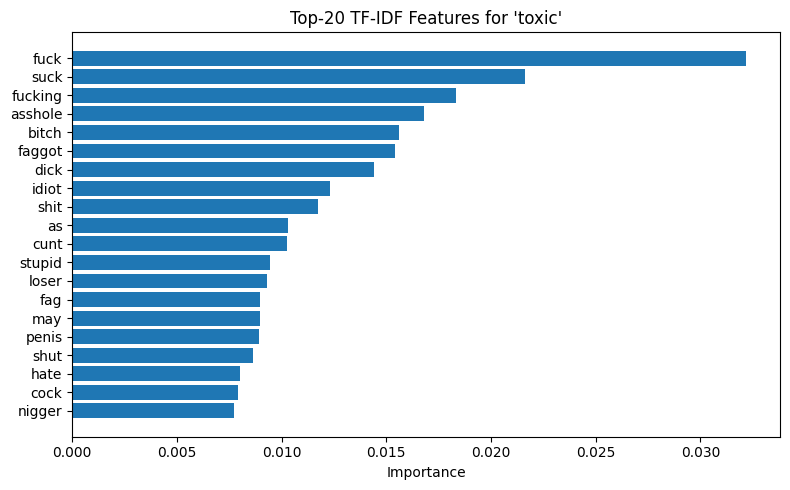

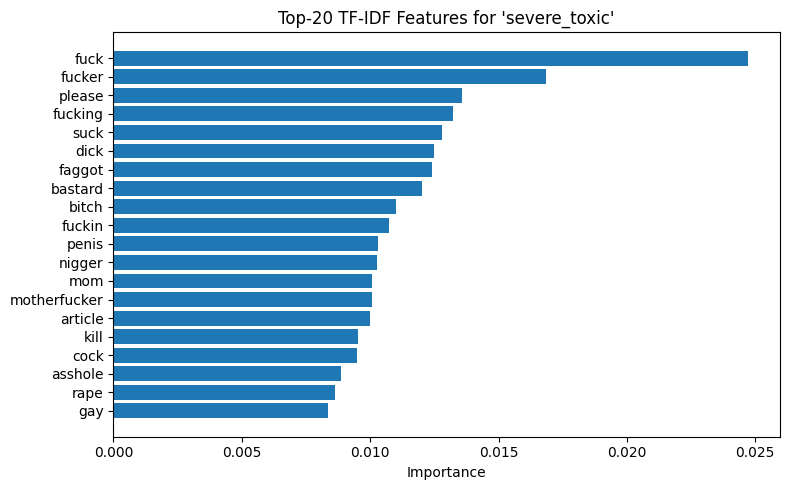

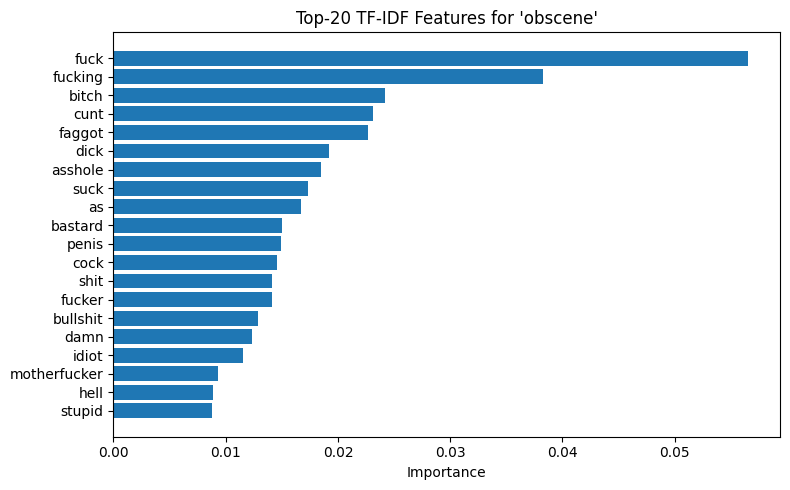

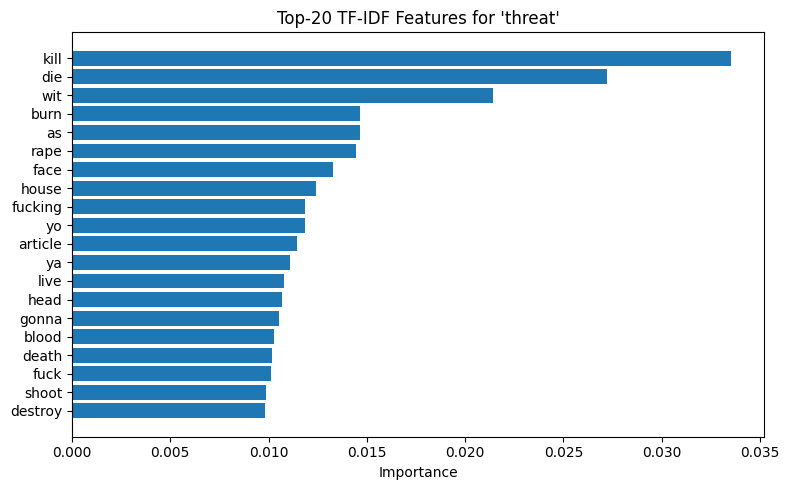

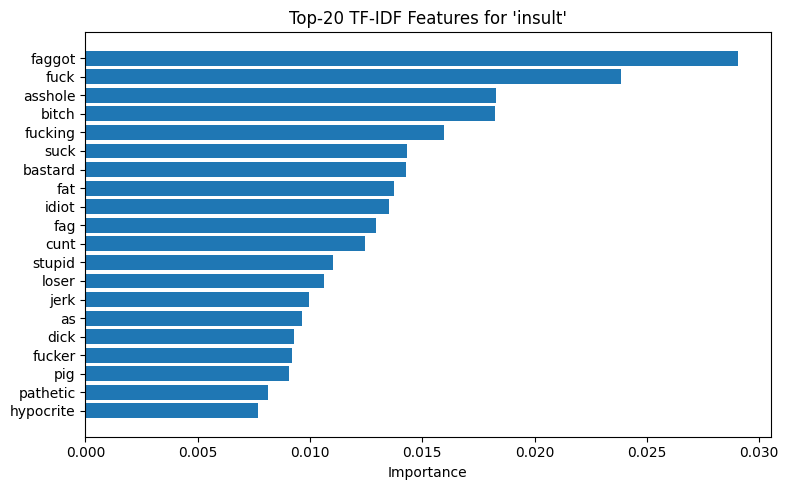

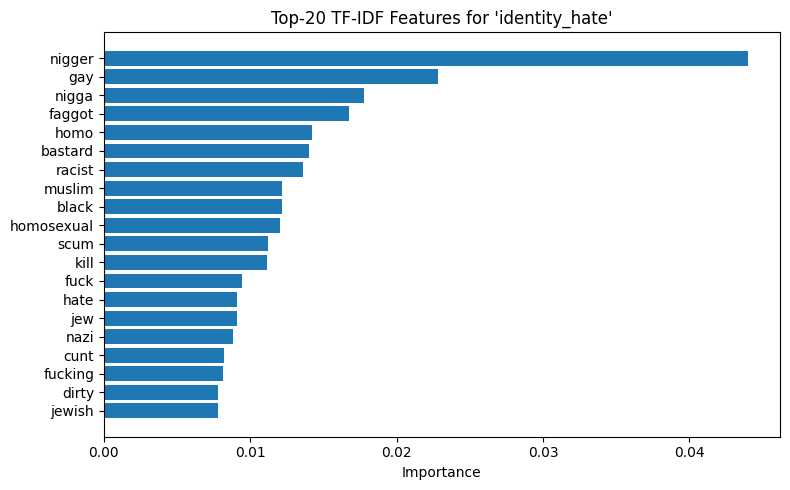

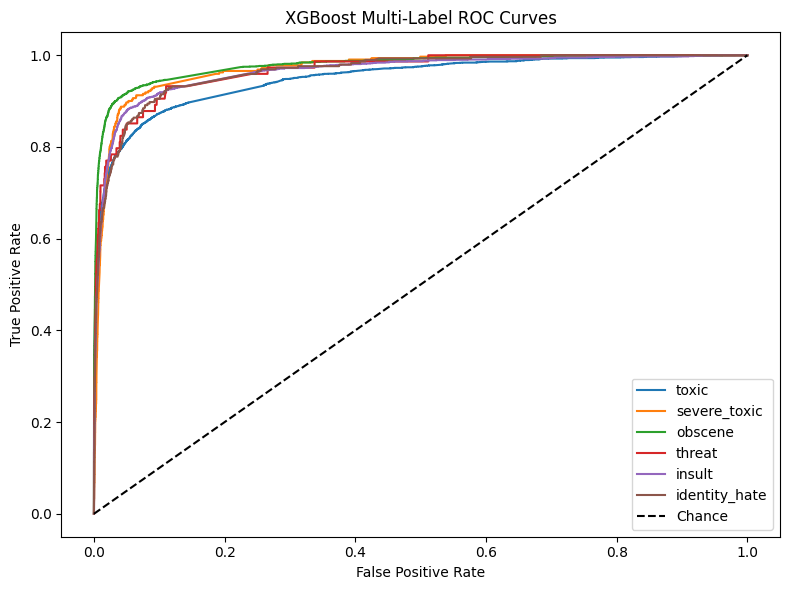

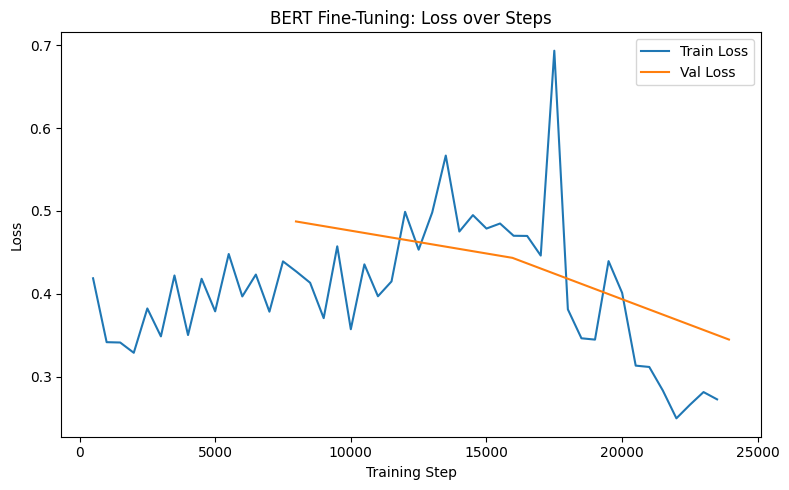

In [41]:


# --- 1. XGBoost: Top-20 Feature Importances per Label ---
feature_names = tfidf_vectorizer.get_feature_names_out()

for idx, label in enumerate(target_cols):
    importances = multi_xgb.estimators_[idx].feature_importances_
    top_idx = np.argsort(importances)[-20:]
    plt.figure(figsize=(8, 5))
    plt.barh(feature_names[top_idx], importances[top_idx])
    plt.title(f"Top-20 TF-IDF Features for '{label}'")
    plt.xlabel("Importance")
    plt.tight_layout()
    plt.show()

# --- 2. XGBoost: ROC Curves for All Six Labels ---
plt.figure(figsize=(8, 6))
for idx, label in enumerate(target_cols):
    fpr, tpr, _ = roc_curve(y_test[label], y_proba[:, idx])
    plt.plot(fpr, tpr, label=label)
plt.plot([0,1], [0,1], 'k--', label='Chance')
plt.title("XGBoost Multi-Label ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

# --- 3. BERT: Training & Validation Loss by Step ---
# Pull the Trainer’s log history into a DataFrame
log_df = pd.DataFrame(trainer.state.log_history)

# Extract and plot training loss entries
train_df = log_df[['step','loss']].dropna()
# Extract and plot evaluation loss entries
val_df   = log_df[['step','eval_loss']].dropna()

plt.figure(figsize=(8, 5))
plt.plot(train_df['step'], train_df['loss'], label='Train Loss')
plt.plot(val_df['step'],   val_df['eval_loss'], label='Val Loss')
plt.title("BERT Fine-Tuning: Loss over Steps")
plt.xlabel("Training Step")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()


In [42]:
# ===  stored metrics for each model: ===

# 1) Capture base XGBoost results (from your per‐label loop)
#    Make sure this cell comes right after your base‐XGB evaluation
xgb_results = results.copy()   # 'results' was the dict you built in step 8 of your base XGB code

# 2) Capture MultiOutput XGBoost results
#    Run this cell right after your multi‐XGB evaluation
multi_results = results.copy()  # reusing the same variable name for your multi‐XGB run

# 3) Capture DistilBERT evaluation metrics
#    Run this after you call `trainer_distil.evaluate()`
distil_eval = trainer.evaluate()   # if your DistilBERT Trainer is named `trainer`
distil_results = {
    'DistilBERT': {
        'Accuracy':  distil_eval['eval_accuracy'],
        'Precision': distil_eval['eval_precision'],
        'Recall':    distil_eval['eval_recall'],
        'F1 Score':  distil_eval['eval_f1']
        # add 'ROC-AUC': distil_eval['eval_roc_auc'] if you computed it
    }
}

# === Build summary tables ===
import pandas as pd

# Base XGBoost table
xgb_df = pd.DataFrame(xgb_results).T
xgb_df.index.name = 'Label'
xgb_df = xgb_df[['Accuracy','F1 Score','ROC-AUC','Precision','Recall']].round(4)

# MultiOutput XGBoost table
multi_df = pd.DataFrame(multi_results).T
multi_df.index.name = 'Label'
multi_df = multi_df[['Accuracy','F1 Score','ROC-AUC','Precision','Recall']].round(4)

# DistilBERT table
distil_df = pd.DataFrame(distil_results).T
distil_df.index.name = 'Model'
distil_df = distil_df[['Accuracy','Precision','Recall','F1 Score']].round(4)

# === Display the tables ===
print("=== 1) Base XGBoost (per-label) ===")
display(xgb_df)

print("\n=== 2) MultiOutput XGBoost ===")
display(multi_df)

print("\n=== 3) DistilBERT ===")
display(distil_df)


{'eval_loss': 0.34476691484451294, 'eval_accuracy': 0.9589221369262102, 'eval_roc_auc': 0.9778324142263888, 'eval_precision': 0.7847467608951708, 'eval_recall': 0.8212634822804314, 'eval_f1': 0.8025899713898509, 'eval_runtime': 53.1122, 'eval_samples_per_second': 600.898, 'eval_steps_per_second': 37.562, 'epoch': 3.0}
=== 1) Base XGBoost (per-label) ===


,Accuracy,F1 Score,ROC-AUC,Precision,Recall
Label,,,,,
toxic,0.9558,0.7249,0.9498,0.8976,0.6080
severe_toxic,0.9900,0.2889,0.9709,0.5039,0.2025
obscene,0.9797,0.7907,0.9781,0.8863,0.7137
threat,0.9978,0.3238,0.9663,0.5484,0.2297
insult,0.9702,0.6543,0.9646,0.7904,0.5582
identity_hate,0.9920,0.3876,0.9645,0.6532,0.2755



=== 2) MultiOutput XGBoost ===


,Accuracy,F1 Score,ROC-AUC,Precision,Recall
Label,,,,,
toxic,0.9558,0.7249,0.9498,0.8976,0.6080
severe_toxic,0.9900,0.2889,0.9709,0.5039,0.2025
obscene,0.9797,0.7907,0.9781,0.8863,0.7137
threat,0.9978,0.3238,0.9663,0.5484,0.2297
insult,0.9702,0.6543,0.9646,0.7904,0.5582
identity_hate,0.9920,0.3876,0.9645,0.6532,0.2755



=== 3) DistilBERT ===


,Accuracy,Precision,Recall,F1 Score
Model,,,,
DistilBERT,0.9589,0.7847,0.8213,0.8026


In [ ]:
# full_pipeline_with_pickle_and_distilbert_legacy.py

# -----------------------------------------------
# 0. — (Optional) Install Compatible Libraries
# -----------------------------------------------
# If using an older transformers (<4.2) in Colab:
# !pip install -q transformers[torch]==4.44.0 torch scikit-learn nltk xgboost

# -----------------------------------------------
# 1. — Imports & NLTK downloads
# -----------------------------------------------
import re
import pickle
import time

import pandas as pd
import numpy as np
import nltk
import torch

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score,
    precision_score, recall_score
)

from xgboost import XGBClassifier

from transformers import (
    DistilBertForSequenceClassification,
    DistilBertTokenizerFast,
    Trainer,
    TrainingArguments
)

# download only lemmatizer and stopwords
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')

# -----------------------------------------------
# 2. — Preprocessing setup
# -----------------------------------------------
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    clean = re.sub(r'[^a-z0-9\s]', ' ', str(text).lower())
    tokens = clean.split()
    tokens = [
        lemmatizer.lemmatize(tok)
        for tok in tokens
        if tok not in stop_words and len(tok) > 1
    ]
    return ' '.join(tokens)

# -----------------------------------------------
# 3. — Load & preprocess data
# -----------------------------------------------
df = pd.read_csv('/content/Dataset/Jigsaw/train.csv')  # adjust path

label_cols = ['toxic','severe_toxic','obscene','threat','insult','identity_hate']

df['clean'] = df['comment_text'].apply(preprocess_text)
X = df['clean']
y = df[label_cols]

# -----------------------------------------------
# 4. — Train/Test split for TF-IDF + XGB
# -----------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    random_state=42,
    stratify=y['toxic']
)

# -----------------------------------------------
# 5. — TF-IDF Vectorization
# -----------------------------------------------
tfidf = TfidfVectorizer(
    max_features=20000,
    ngram_range=(1,2),
    strip_accents='unicode'
)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf  = tfidf.transform(X_test)

# -----------------------------------------------
# 6. — Train Multi-Output XGBoost
# -----------------------------------------------
multi_xgb = MultiOutputClassifier(
    XGBClassifier(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42
    )
)

print("⏳ Training XGBoost pipeline…")
multi_xgb.fit(X_train_tfidf, y_train)
print(" XGBoost training complete.")

# -----------------------------------------------
# 7. — Evaluate XGBoost
# -----------------------------------------------
print("\n--- XGBoost Test Performance ---")
for i, lbl in enumerate(label_cols):
    pred = multi_xgb.predict(X_test_tfidf)[:, i]
    print(f"{lbl:15s} | acc={accuracy_score(y_test[lbl],pred):.3f} "
          f"| f1={f1_score(y_test[lbl],pred):.3f} "
          f"| roc_auc={roc_auc_score(y_test[lbl],pred):.3f} "
          f"| prec={precision_score(y_test[lbl],pred):.3f} "
          f"| rec={recall_score(y_test[lbl],pred):.3f}")

# -----------------------------------------------
# 8. — Save TF-IDF & XGB as Pickles
# -----------------------------------------------
with open('tfidf_vectorizer.pkl','wb') as f:
    pickle.dump(tfidf, f)
print(" Saved tfidf_vectorizer.pkl")

with open('multi_xgb_model.pkl','wb') as f:
    pickle.dump(multi_xgb, f)
print(" Saved multi_xgb_model.pkl")



[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


⏳ Training XGBoost pipeline…


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:36:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:38:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:39:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:41:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:42:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

✅ XGBoost training complete.

--- XGBoost Test Performance ---
toxic           | acc=0.948 | f1=0.645 | roc_auc=0.744 | prec=0.935 | rec=0.492
severe_toxic    | acc=0.990 | f1=0.257 | roc_auc=0.584 | prec=0.525 | rec=0.170
obscene         | acc=0.978 | f1=0.762 | roc_auc=0.829 | prec=0.894 | rec=0.663
threat          | acc=0.997 | f1=0.193 | roc_auc=0.557 | prec=0.647 | rec=0.113
insult          | acc=0.969 | f1=0.617 | roc_auc=0.748 | prec=0.801 | rec=0.502
identity_hate   | acc=0.992 | f1=0.391 | roc_auc=0.634 | prec=0.709 | rec=0.270
✅ Saved tfidf_vectorizer.pkl
✅ Saved multi_xgb_model.pkl


In [6]:
# -----------------------------------------------
#  Imports & NLTK downloads
# -----------------------------------------------
import os
os.environ["WANDB_DISABLED"] = "true"
import re
import pickle
import time

import pandas as pd
import numpy as np
import nltk
import torch

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score,
    precision_score, recall_score
)

from xgboost import XGBClassifier

from transformers import (
    DistilBertForSequenceClassification,
    DistilBertTokenizerFast,
    Trainer,
    TrainingArguments
)

# download only lemmatizer and stopwords
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')

# -----------------------------------------------
# Preprocessing setup
# -----------------------------------------------
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    clean = re.sub(r'[^a-z0-9\s]', ' ', str(text).lower())
    tokens = clean.split()
    tokens = [
        lemmatizer.lemmatize(tok)
        for tok in tokens
        if tok not in stop_words and len(tok) > 1
    ]
    return ' '.join(tokens)

# -----------------------------------------------
#  Load & preprocess data
# -----------------------------------------------
df = pd.read_csv('/content/Dataset/Jigsaw/train.csv')  # adjust path

label_cols = ['toxic','severe_toxic','obscene','threat','insult','identity_hate']

df['clean'] = df['comment_text'].apply(preprocess_text)
X = df['clean']
y = df[label_cols]


# 9. Prepare DistilBERT dataset
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
encodings = tokenizer(
    df['comment_text'].tolist(),
    truncation=True, padding='max_length', max_length=128,
    return_tensors='pt'
)
labels_tensor = torch.tensor(df[label_cols].values, dtype=torch.float)

class MultiLabelDataset(torch.utils.data.Dataset):
    def __init__(self, enc, labs):
        self.enc = enc; self.labels = labs
    def __len__(self): return len(self.labels)
    def __getitem__(self, idx):
        item = {k: v[idx] for k,v in self.enc.items()}
        item['labels'] = self.labels[idx]
        return item

dataset = MultiLabelDataset(encodings, labels_tensor)
train_size = int(0.8 * len(dataset))
train_ds, val_ds = torch.utils.data.random_split(
    dataset, [train_size, len(dataset)-train_size]
)

# 10. Initialize DistilBERT model
model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    problem_type="multi_label_classification",
    num_labels=len(label_cols)
)

# 11. TrainingArguments without eval/save flags
training_args = TrainingArguments(
    output_dir='./distil_results',
    num_train_epochs=2,
    per_device_train_batch_size=16,
    logging_dir='./distil_logs'
)

# 12. Trainer & fine-tune (no automatic eval during training)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    tokenizer=tokenizer
)
print("\nFine-tuning DistilBERT (no eval)…")
t0 = time.time()
trainer.train()
print(f"Fine-tuning done in {time.time() - t0:.1f}s")

# 13. (Optional) Manual evaluation
print("\n🔍 Manual evaluation on validation set:")
preds = trainer.predict(val_ds)
if 'eval_loss' in preds.metrics:
    print(f"Validation loss: {preds.metrics['eval_loss']:.3f}")

# 14. Save DistilBERT model & tokenizer
model.save_pretrained('distil_toxic_classifier')
tokenizer.save_pretrained('distil_toxic_classifier')
print(" Saved DistilBERT to ./distil_toxic_classifier/")

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/tmp/ipython-input-6-880898764.py:108: FutureWarning: `tokenizer` is deprecated and will be removed


Fine-tuning DistilBERT (no eval)…


Step,Training Loss
500,0.090200
1000,0.053500
1500,0.052700
2000,0.047000
2500,0.046800
3000,0.050400
3500,0.045100
4000,0.046600
4500,0.043500
5000,0.044700


Fine-tuning done in 5039.2s

🔍 Manual evaluation on validation set:


 Saved DistilBERT to ./distil_toxic_classifier/


In [8]:
# -----------------------------------------------
# 8. —  Quick Inference Example
# -----------------------------------------------
# Uncomment to test loading & inference:
#
with open('tfidf_vectorizer.pkl','rb') as f: tfidf_loaded = pickle.load(f)
with open('multi_xgb_model.pkl','rb')   as f: model_loaded = pickle.load(f)
#
samples = ["You're amazing!", "I will hurt you."]
clean_samples = [preprocess_text(s) for s in samples]
X_new = tfidf_loaded.transform(clean_samples)
preds = model_loaded.predict(X_new)
print("Predictions:", preds)



Predictions: [[0 0 0 0 0 0]
 [0 0 0 0 0 0]]
